- fhs_flashsale_product: (Thông tin flashsale của product)
    * period_id : id của flashsale
    * product_id : id của product 
    * original_price : giá gốc
    * flashsale_price : giá sale
    * total_items : số lượng sale
    
- fhs_flashsale_period: (Chứa thông tin flashsale về thời gian)
    * id: id của flashsale (== period_id của fhs_flashsale_product)
    * start_date, end_date: time bắt đầu kết thúc sale 
    * các cột khác không quan tâm
    
- fhs_catalog_product_entity: (Thông tin discount và ngày bắt đầu bán)
    * entity_id: id của product (==product_id trong fhs_flashsale_product)
    * sku : là mã sản phẩm (duy nhất và là khóa của sản phẩm dùng để truy các thông tin khác về sản phẩm)
    * created_at : ngày bắt đầu bán
    * discount_percent : phần trăm giảm giá so với giá bìa (trừ flashsale còn giá sản phẩm mọi lúc sẽ là giá gốc trừ đi disount này)

- fhs_cataloginventory_stock_item: Bãng này là số lượng sản phẩm tồn nhưng ko dùng được, do bên db bị mất dữ liệu
    
- fhs_sales_flat_order: Chứa thông tin đơn hàng
    * entity_id : id của đơn hàng (==order_id trong fhs_sales_flat_order_item)
    * state : trạng thái đơn hàng
    * status : trạng thái của trạng thái đơn hàng (ví dụ đơn hàng ở state đang giao, status là complete nghĩa là ở trang thái đang * giao đã hoàn thành)
    * created_at : ngày tạo đơn
    * updated_at : ngày cập nhật trạng thái
    * store_id : id của kho, id < 4 cho thương mại điện tử  (nhớ thêm điều kiện store_id<4 khi query bảng này)

- fhs_sales_flat_order_item: Chưa thông tin từng sản phẩm trong đơn hàng
    * order_id: id của đơn hàng (==entity_id trong fhs_sales_flat_order)
    * created_at: Ngày tạo đơn con
    * product_id, sku : id và mã sản phẩm

- fhs_catalog_product_entity_decimal: Bảng giá sản phẩm
    * entity_id: id của product (==entity_id trong fhs_catalog_product_entity)
    * attribute_id : loại giá (giá gốc 75, giá bán 76 (hoặc ngược lại chị không nhớ, chỉ quan tâm 2 loại này))
    * value : giá bán của sản phẩm với attribute tương ứng
    
- fhs_product_stock_log: Bảng này là thông tin các sản phẩm đang bán hiện tại trên thị trường
    * product_id, sku : id và mã của sp
    * qty: số lượng trong kho
    * is_in_stock: 1 là còn bán
    * created_at: không rõ
    * bảng này cũng không đáng tin lắm 
    
- product_dim : Thông tin sp
    * sku: mã
    * name: tên
    * cat1 tới cat5: là categories của sp
    * price : giá gốc

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

- Đọc các file csv vào các biến tương ứng

In [191]:
fhs_flashsale_product = pd.read_csv('../Data/Data_Fahasa/fhs_flashsale_product.csv')
fhs_flashsale_period = pd.read_csv('../Data/Data_Fahasa/fhs_flashsale_period.csv')
fhs_catalog_product_entity = pd.read_csv('../Data/Data_Fahasa/fhs_catalog_product_entity.csv')
fhs_sales_flat_order = pd.read_csv('../Data/Data_Fahasa/fhs_sales_flat_order.csv')
fhs_sales_flat_order_item = pd.read_csv('../Data/Data_Fahasa/fhs_sales_flat_order_item.csv')
fhs_catalog_product_entity_decimal = pd.read_csv('../Data/Data_Fahasa/fhs_catalog_product_entity_decimal.csv')
fhs_product_stock_log = pd.read_csv('../Data/Data_Fahasa/fhs_product_stock_log.csv')
product_dim = pd.read_csv('../Data/Data_Fahasa/product_dim.csv')

- Đổi tên các cột theo tên của từng file cho dễ nhận dạng

In [192]:
def rename_columns(dataframe, dataframe_name):
    """
    rename columns with patern: dataframe_name.columns_name
    Input:
        dataframe: Dataframe Pandas
        dataframe_name: string
    """
    columns = dataframe.columns
    # rename columns
    new_names = []
    for index in range(len(columns)):
        new_name = f'{dataframe_name}.{columns[index]}'
        new_names.append(new_name)
    
    dataframe.columns = new_names

rename_columns(fhs_flashsale_product, 'fhs_flashsale_product')
rename_columns(fhs_flashsale_period, 'fhs_flashsale_period')
rename_columns(fhs_catalog_product_entity, 'fhs_catalog_product_entity')
rename_columns(fhs_sales_flat_order, 'fhs_sales_flat_order')
rename_columns(fhs_sales_flat_order_item, 'fhs_sales_flat_order_item')
rename_columns(fhs_catalog_product_entity_decimal, 'fhs_catalog_product_entity_decimal')
rename_columns(fhs_product_stock_log, 'fhs_product_stock_log')
rename_columns(product_dim, 'product_dim')

- Xóa các cột không cần thiết của fhs_flashsale_period

In [193]:
temp = fhs_flashsale_period.loc[:,
    ['fhs_flashsale_period.id', 'fhs_flashsale_period.start_date', 'fhs_flashsale_period.end_date']]
# xóa đi để tiết kiệm bộ nhớ
del fhs_flashsale_period
fhs_flashsale_period = temp

- Chuyển các chuỗi thời gian về định dạng datetime

In [194]:
def string_to_datetime(dataframe, column_name):
          dataframe[f'{column_name}'] \
          = pd.to_datetime(dataframe[f'{column_name}'],
                              format = '%Y/%m/%d %H:%M:%S')

string_to_datetime(fhs_flashsale_period, 'fhs_flashsale_period.start_date')
string_to_datetime(fhs_flashsale_period, 'fhs_flashsale_period.end_date')
string_to_datetime(fhs_catalog_product_entity, 'fhs_catalog_product_entity.created_at')
string_to_datetime(fhs_sales_flat_order, 'fhs_sales_flat_order.created_at')
string_to_datetime(fhs_sales_flat_order, 'fhs_sales_flat_order.updated_at')
string_to_datetime(fhs_sales_flat_order_item, 'fhs_sales_flat_order_item.created_at')
string_to_datetime(fhs_product_stock_log, 'fhs_product_stock_log.created_at')

In [195]:
print('fhs_flashsale_product', len(fhs_flashsale_product))
print('fhs_flashsale_period', len(fhs_flashsale_period))
print('fhs_product_stock_log',len(fhs_product_stock_log))
print('fhs_catalog_product_entity',len(fhs_catalog_product_entity))
print('fhs_catalog_product_entity_decimal',len(fhs_catalog_product_entity_decimal))
print('fhs_sales_flat_order',len(fhs_sales_flat_order))
print('fhs_sales_flat_order_item',len(fhs_sales_flat_order_item))
print('product_dim',len(product_dim))

fhs_flashsale_product 3930772
fhs_flashsale_period 6416
fhs_product_stock_log 10251317
fhs_catalog_product_entity 352880
fhs_catalog_product_entity_decimal 1213003
fhs_sales_flat_order 3541823
fhs_sales_flat_order_item 17828291
product_dim 2961504


- Merge thông tin của các sản phẩm flashsale lại với nhau để lấy các thông tin cần thiết như: ()
  * Mã sku
  * Thời gian flashsale của từng sản phẩm
  * ......

In [196]:
temp = pd.merge(fhs_flashsale_product, fhs_flashsale_period, 
          left_on='fhs_flashsale_product.period_id', right_on='fhs_flashsale_period.id')
fhs_flashsale_product_info = pd.merge(temp, fhs_catalog_product_entity, 
          left_on='fhs_flashsale_product.product_id', right_on='fhs_catalog_product_entity.entity_id')
del temp
fhs_flashsale_product_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3930772 entries, 0 to 3930771
Data columns (total 12 columns):
 #   Column                                       Dtype         
---  ------                                       -----         
 0   fhs_flashsale_product.period_id              int64         
 1   fhs_flashsale_product.product_id             int64         
 2   fhs_flashsale_product.original_price         float64       
 3   fhs_flashsale_product.flashsale_price        float64       
 4   fhs_flashsale_product.total_items            float64       
 5   fhs_flashsale_period.id                      int64         
 6   fhs_flashsale_period.start_date              datetime64[ns]
 7   fhs_flashsale_period.end_date                datetime64[ns]
 8   fhs_catalog_product_entity.entity_id         int64         
 9   fhs_catalog_product_entity.sku               object        
 10  fhs_catalog_product_entity.created_at        datetime64[ns]
 11  fhs_catalog_product_entity.discount_p

- Tương tự với đơn hàng, ta sẽ merge giữa đơn hàng chính và đơn hàng con để tập trung vào các thuộc tính:
  * Trạng thái đơn hàng chính
  * Ngày tạo đơn hàng con

In [197]:
fhs_sales_flat_order_item_state  \
        = pd.merge(fhs_sales_flat_order, fhs_sales_flat_order_item,
                        left_on = 'fhs_sales_flat_order.entity_id', 
                        right_on = 'fhs_sales_flat_order_item.order_id')

fhs_sales_flat_order_item_state.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13969403 entries, 0 to 13969402
Data columns (total 12 columns):
 #   Column                                Dtype         
---  ------                                -----         
 0   fhs_sales_flat_order.entity_id        int64         
 1   fhs_sales_flat_order.increment_id     float64       
 2   fhs_sales_flat_order.state            object        
 3   fhs_sales_flat_order.status           object        
 4   fhs_sales_flat_order.created_at       datetime64[ns]
 5   fhs_sales_flat_order.updated_at       datetime64[ns]
 6   fhs_sales_flat_order.store_id         int64         
 7   fhs_sales_flat_order_item.item_id     int64         
 8   fhs_sales_flat_order_item.order_id    int64         
 9   fhs_sales_flat_order_item.created_at  datetime64[ns]
 10  fhs_sales_flat_order_item.product_id  float64       
 11  fhs_sales_flat_order_item.sku         object        
dtypes: datetime64[ns](3), float64(2), int64(4), object(3)
memory usage: 

- Vì số lượng dòng quá lớn nên ta sẽ thực hiện chiến lược tách các sản phẩm theo từng nhóm:
  * Theo năm: và mỗi năm chỉ lấy ra những sản phẩm bán chạy nhất hoặc lấy những sản phẩm trung bình
  * Có thể nghĩ đến chiến thuật lấy ngẫu nhiên sau đó dùng thống kê mô tả để dự đoán ảnh hưởng của flashsale đến lưu lượng bán hàng

In [198]:
# Giả sử xét trong năm 2022
import datetime 
min_year = pd.to_datetime('2022/1/1',
                              format = '%Y/%m/%d %H:%M:%S')
max_year = pd.to_datetime('2022/12/31 23:59:59',
                              format = '%Y/%m/%d %H:%M:%S')

condition2 = np.where((fhs_sales_flat_order_item_state['fhs_sales_flat_order_item.created_at'] >=  min_year)
          &           (fhs_sales_flat_order_item_state['fhs_sales_flat_order_item.created_at'] <=  max_year))     
fhs_sales_flat_order_item_state_2022 = fhs_sales_flat_order_item_state.loc[condition2] 

# Tương ứng với những sản phẩm được tung ra trong khoảng thời gian này 2022
condition3 = np.where((fhs_flashsale_product_info['fhs_flashsale_period.start_date'] >=  min_year)
          &           (fhs_flashsale_product_info['fhs_flashsale_period.start_date'] <=  max_year))
fhs_flashsale_product_info_2022 = fhs_flashsale_product_info.loc[condition3] 

In [199]:
# fhs_sales_flat_order_item_state_2022 = pd.read_csv('Data/fhs_sales_flat_order_item_state_2022.csv')
# fhs_flashsale_product_info_2022 = pd.read_csv('Data/fhs_flashsale_product_info_2022.csv')

In [200]:
print(len(fhs_sales_flat_order_item_state_2022))
print(len(fhs_flashsale_product_info_2022))

997797
797530


- Tạo thêm 4 cột giá trị, để có sau này truy vấn đơn giản hơn cho fhs_sales_flat_order_item_state:
  * flashsale_product: Có phải là đơn hàng flashsale hay không
  * flashsale_day: True là trong ngày có flashsale, False ngược lại
  * flashsale_time: True là trong khung giờ có flashsale, False ngược lại
  * flashsale_time_product: True thời gian này sản phẩm đó được flashsale, False ngược lại


- Đầu tiên là xác định có phải đơn hàng flashsale hay không

In [201]:
fhs_sales_flat_order_item_state_2022['flashsale_product'] = fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.sku']\
          .isin(fhs_flashsale_product_info_2022['fhs_catalog_product_entity.sku'])


- Tiếp theo là xem có ở trong ngày flashsale hay không

In [202]:
len(fhs_sales_flat_order_item_state_2022)

997797

In [203]:
# fhs_flashsale_product_info_2022.drop(['Unnamed: 0'], axis = 1, inplace=True)

- Xem xét sản phẩm đó có bán trong ngày flashsale hay không

In [204]:
dayofyear_flashsale = set(fhs_flashsale_product_info_2022\
          .groupby(fhs_flashsale_product_info_2022['fhs_flashsale_period.start_date'].dt.dayofyear).keys)

In [205]:
fhs_sales_flat_order_item_state_2022['flashsale_day'] = \
          np.where(fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.dayofyear.isin(dayofyear_flashsale)
                    , True, False)

- Xem xét sản phẩm có bán trong khung giờ có flash sale hay không

In [206]:
# Đầu tiên cho những thuộc tính flashsale_time bằng false hết sau đó ta sẽ gán True vào những dòng cần thiết
fhs_sales_flat_order_item_state_2022['flashsale_time'] = False

In [207]:
# Lấy các ngày sale có trong flash sale
start_end = fhs_flashsale_product_info_2022.groupby(
                    [fhs_flashsale_product_info_2022['fhs_flashsale_period.start_date'],
                    fhs_flashsale_product_info_2022['fhs_flashsale_period.end_date']])['fhs_flashsale_product.period_id'].count()
                    

In [208]:
# tạo ra dataframe để merge lại r so sánh
start_end_df = pd.DataFrame(
          {'start': start_end.index.get_level_values(0),
           'end': start_end.index.get_level_values(1)})

# merge các cột có cùng ngày với nhau
temp = \
          pd.merge(fhs_sales_flat_order_item_state_2022, start_end_df,
                    left_on = fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.dayofyear
                    ,right_on = start_end_df['start'].dt.dayofyear)

# lọc đi các dòng không thuộc thời gian flashsale
temp = temp.loc[(temp['fhs_sales_flat_order_item.created_at'] \
                    > temp['start'])
&         (temp['fhs_sales_flat_order_item.created_at'] \
                    < temp['end'])]
          
# drop đi duplicate ở mỗi đơn hàng
temp.drop_duplicates(subset = fhs_sales_flat_order_item_state_2022.columns, inplace = True)

# Cắt cột
fhs_sales_flat_order_item_flashsale_time_2022 =\
           temp.loc[:, fhs_sales_flat_order_item_state_2022.columns]

#  Xử lí để gán vào cho flashsale_time
keys = list(fhs_sales_flat_order_item_state_2022.columns)
i1 = fhs_sales_flat_order_item_state_2022.set_index(keys).index
i2 = fhs_sales_flat_order_item_flashsale_time_2022.set_index(keys).index


fhs_sales_flat_order_item_state_2022['flashsale_time'] = \
          np.where(i1.isin(i2),
          True, False)


- Xet thử sản phẩm trong giờ đó có flashsale hay không

In [209]:
# Đầu tiên cho những thuộc tính flashsale_time_product bằng false hết sau đó ta sẽ gán True vào những dòng cần thiết
fhs_sales_flat_order_item_state_2022['flashsale_time_product'] = False

In [210]:
temp = \
          pd.merge(fhs_sales_flat_order_item_state_2022, fhs_flashsale_product_info_2022,
                    left_on = 'fhs_sales_flat_order_item.sku'
                    ,right_on = 'fhs_catalog_product_entity.sku')

# Lấy các dòng sao cho lọt vào thời điểm flashsale
temp = temp.loc[
          (temp['fhs_sales_flat_order_item.created_at'] \
                    > temp['fhs_flashsale_period.start_date'])
&         (temp['fhs_sales_flat_order_item.created_at'] \
                    < temp['fhs_flashsale_period.end_date'])]

# drop đi duplicate ở mỗi đơn hàng
temp.drop_duplicates(subset = fhs_sales_flat_order_item_state_2022.columns, inplace = True)

# Cắt cột
fhs_sales_flat_order_item_flashsale_time_product_2022 =\
           temp.loc[:, fhs_sales_flat_order_item_state_2022.columns]

#  Xử lí để gán vào cho flashsale_time
keys = list(fhs_sales_flat_order_item_state_2022.columns)
i1 = fhs_sales_flat_order_item_state_2022.set_index(keys).index
i2 = fhs_sales_flat_order_item_flashsale_time_product_2022.set_index(keys).index


fhs_sales_flat_order_item_state_2022['flashsale_time_product'] = \
          np.where(i1.isin(i2),
          True, False)


In [211]:
a = fhs_sales_flat_order_item_state_2022.loc[
          (fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order.state'] == 'complete')
&         (fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order.status'] == 'complete')]

In [212]:
a.groupby(['flashsale_product', 'flashsale_day', 'flashsale_time', 'flashsale_time_product']).count()

fhs_sales_flat_order.entity_id  \
flashsale_product flashsale_day flashsale_time flashsale_time_product                                   
False             False         False          False                                            60536   
                  True          False          False                                            59056   
                                True           False                                           224315   
True              False         False          False                                            45902   
                  True          False          False                                            57176   
                                True           False                                           234309   
                                               True                                             39106   

                                                                       fhs_sales_flat_order.increment_id  \
flashsale_product flashsale_day flashsale_time flashsale_time_product                                      
False             False         False          False                                               60536   
                  True          False          False                                               59056   
                                True           False                                              224315   
True              False         False          False                                               45902   
                  True          False          False                                               57176   
                                True           False                                              234309   
                                               True                                                39106   

                                                                       fhs_sales_flat_order.state  \
flashsale_product flashsale_day flashsale_time flashsale_time_product                               
False             False         False          False                                        60536   
                  True          False          False                                        59056   
                                True           False                                       224315   
True              False         False          False                                        45902   
                  True          False          False                                        57176   
                                True           False                                       234309   
                                               True                                         39106   

                                                                       fhs_sales_flat_order.status  \
flashsale_product flashsale_day flashsale_time flashsale_time_product                                
False             False         False          False                                         60536   
                  True          False          False                                         59056   
                                True           False                                        224315   
True              False         False          False                                         45902   
                  True          False          False                                         57176   
                                True           False                                        234309   
                                               True                                          39106   

                                                                       fhs_sales_flat_order.created_at  \
flashsale_product flashsale_day flashsale_time flashsale_time_product                                    
False             False         False          False                                             60536   
     

- Bên kia khác kết quả ở chỗ merge bằng sku nên có vài ngày nó không bao gồm trong đó nên sẽ thống kê thiếu.
- Bên đây chúng ta đã thống kê đầy đủ hơn

- Ta show ra các tính trạng các đơn hàng

In [213]:
fhs_sales_flat_order_item_state_2022  \
          .groupby(['fhs_sales_flat_order.state'])['fhs_sales_flat_order.entity_id'].count()


fhs_sales_flat_order.state
canceled      246573
complete      720400
completed         12
new              692
processing     30120
Name: fhs_sales_flat_order.entity_id, dtype: int64

In [214]:
fhs_sales_flat_order_item_state_2022.to_csv('Data/fhs_sales_flat_order_item_state_2022.csv')
fhs_flashsale_product_info_2022.to_csv('Data/fhs_flashsale_product_info_2022.csv')

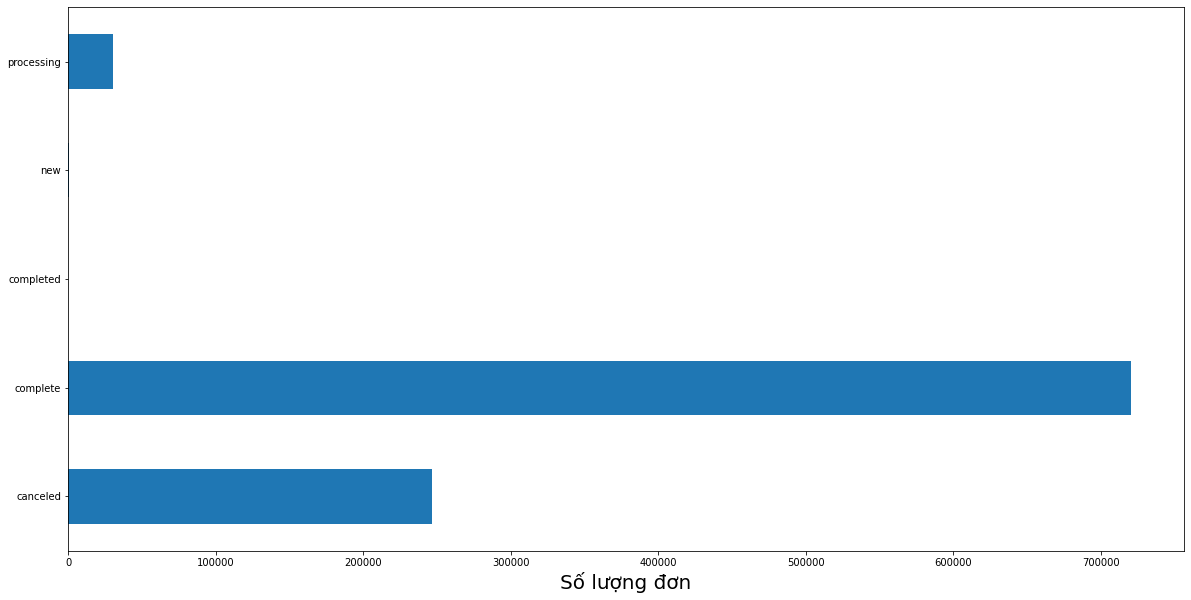

In [25]:
df = fhs_sales_flat_order_item_state_2022  \
          .groupby(['fhs_sales_flat_order.state'])['fhs_sales_flat_order.entity_id'].count()

ax = df.plot.barh(figsize = (20, 10))
ax.set_ylabel('')
ax.set_xlabel('Số lượng đơn')
ax.xaxis.label.set_fontsize(20)

- Ta tập trung xử lí vào đơn complete và canceled

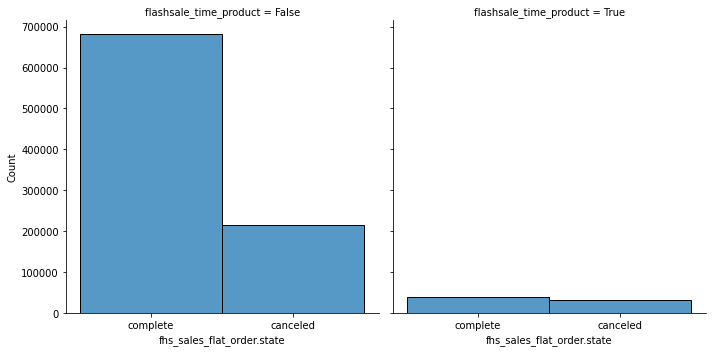

In [26]:
fhs_sales_flat_order_item_state_2022 = \
          fhs_sales_flat_order_item_state_2022\
                    .loc[(fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order.state'].isin(['complete', 'canceled']))
                    &    (fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order.status'].isin(['complete', 'canceled']))]

df = fhs_sales_flat_order_item_state_2022  \
          .groupby(['fhs_sales_flat_order.state', 'flashsale_time_product'])\
                    ['fhs_sales_flat_order.entity_id'].count()

sns.displot(data = fhs_sales_flat_order_item_state_2022, 
          x = 'fhs_sales_flat_order.state', col = 'flashsale_time_product')

- Xử lí với các đơn complete

In [152]:
fhs_sales_flat_order_item_state_2022 = \
          fhs_sales_flat_order_item_state_2022\
                    .loc[(fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order.state'].isin(['complete']))
                    &    (fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order.status'].isin(['complete']))]


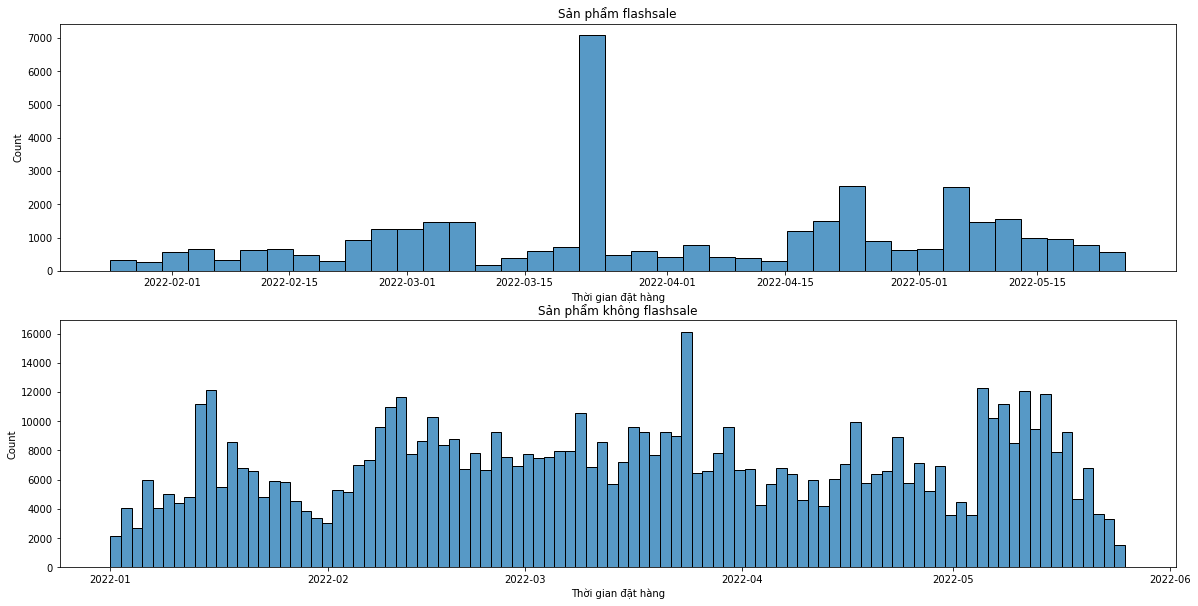

In [155]:
fig, ax = plt.subplots(2, 1, figsize=(20,10))
sns.histplot(data = fhs_sales_flat_order_item_state_2022
                              .loc[fhs_sales_flat_order_item_state_2022['flashsale_time_product'] == True], 
          x = 'fhs_sales_flat_order_item.created_at', ax = ax[0])
ax[0].set_title('Sản phẩm flashsale')
ax[0].set_xlabel('Thời gian đặt hàng')
sns.histplot(data = fhs_sales_flat_order_item_state_2022
                              .loc[fhs_sales_flat_order_item_state_2022['flashsale_time_product'] == False], 
          x = 'fhs_sales_flat_order_item.created_at', ax = ax[1])
ax[1].set_title('Sản phẩm không flashsale')
ax[1].set_xlabel('Thời gian đặt hàng');

Text(0.5, 1.0, 'Lượng mua hàng trung bình trong tháng của các đơn hàng flashsale')

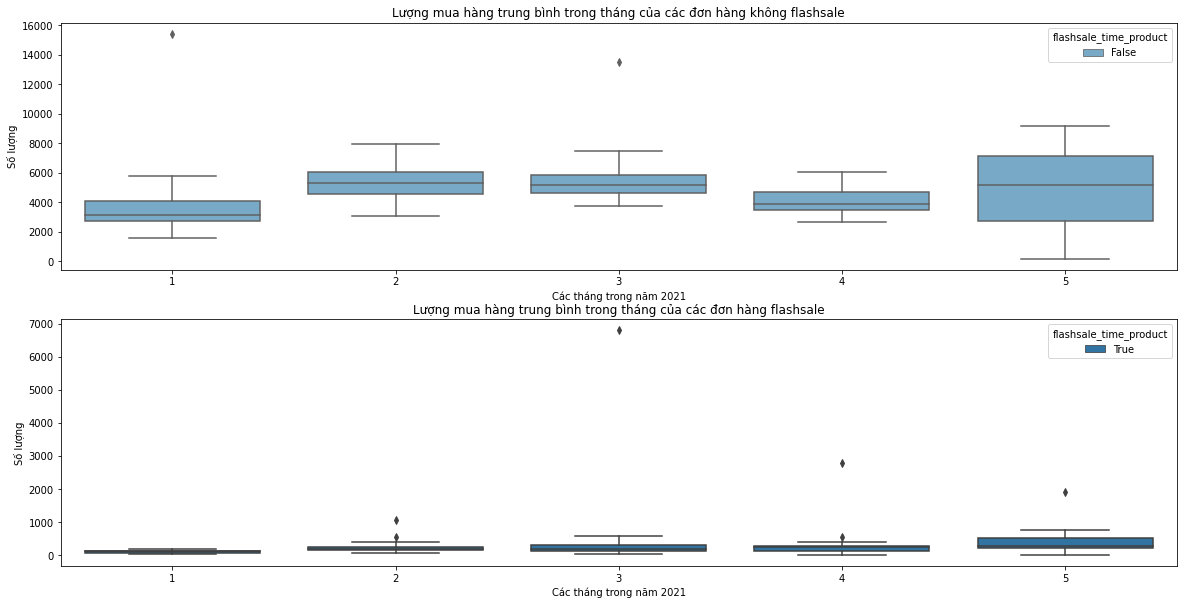

In [156]:
df = fhs_sales_flat_order_item_state_2022         \
          .groupby([fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.date,
                    'flashsale_time_product'])\
                    ['fhs_sales_flat_order.entity_id'].count()

# reset index đưa về dataframe
df = df.reset_index()

# khi reset_index inedx đã đưa về sting nên ta cast về datetime
string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')

# tạo cột bằng 1 để cho biết đơn hàng tính là 1
fhs_sales_flat_order_item_state_2022['temp'] = 1

fig, ax = plt.subplots(2, 1, figsize=(20,10))

df1 = df.loc[df['flashsale_time_product'] == False]
sns.boxplot(data = df1, 
          x = df1['fhs_sales_flat_order_item.created_at'].dt.month,
          y = df1['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_time_product', ax = ax[0], palette="Blues")
ax[0].set_xlabel('Các tháng trong năm 2021')
ax[0].set_ylabel('Số lượng')
ax[0].set_title('Lượng mua hàng trung bình trong tháng của các đơn hàng không flashsale')

df2 = df.loc[df['flashsale_time_product'] == True]
sns.boxplot(data = df2, 
          x = df2['fhs_sales_flat_order_item.created_at'].dt.month,
          y = df2['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_time_product', ax = ax[1],palette = "tab10")
ax[1].set_xlabel('Các tháng trong năm 2021')
ax[1].set_ylabel('Số lượng')
ax[1].set_title('Lượng mua hàng trung bình trong tháng của các đơn hàng flashsale')



Text(0.5, 1.0, 'Lượng mua hàng trung bình trong tháng các ngày trong tuần các đơn hàng flashsale')

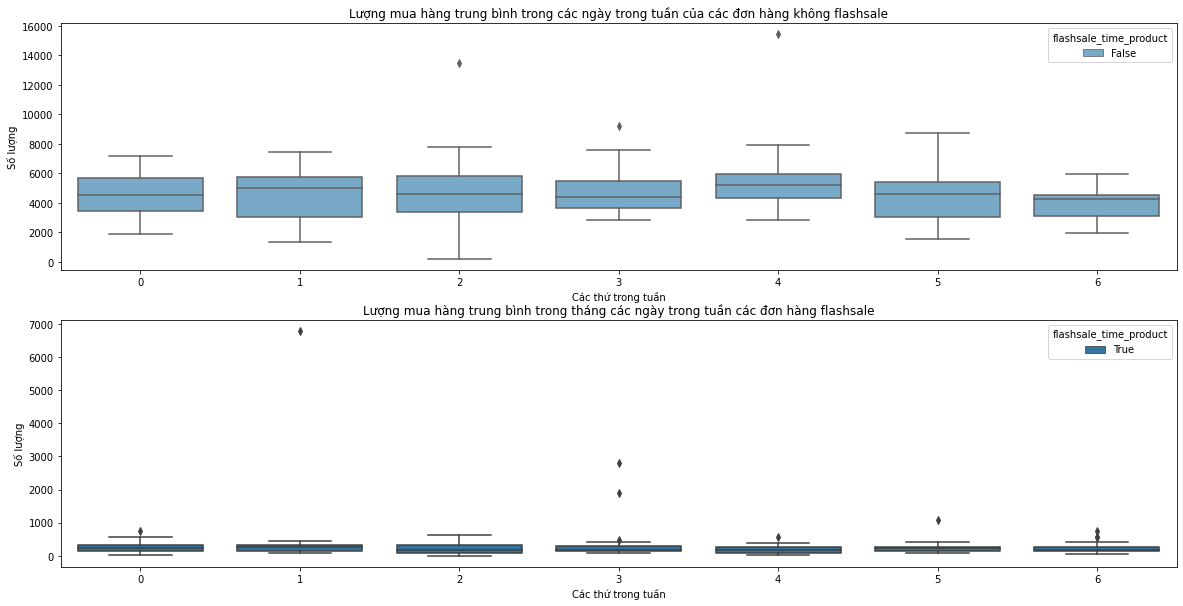

In [158]:
df = fhs_sales_flat_order_item_state_2022         \
          .groupby([fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.date,
                    'flashsale_time_product'])\
                    ['fhs_sales_flat_order.entity_id'].count()

# reset index đưa về dataframe
df = df.reset_index()

# khi reset_index inedx đã đưa về sting nên ta cast về datetime
string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')

# tạo cột bằng 1 để cho biết đơn hàng tính là 1
fhs_sales_flat_order_item_state_2022['temp'] = 1

fig, ax = plt.subplots(2, 1, figsize=(20,10))

df1 = df.loc[df['flashsale_time_product'] == False]
sns.boxplot(data = df1, 
          x = df1['fhs_sales_flat_order_item.created_at'].dt.dayofweek,
          y = df1['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_time_product', ax = ax[0], palette="Blues")
ax[0].set_xlabel('Các thứ trong tuần')
ax[0].set_ylabel('Số lượng')
ax[0].set_title('Lượng mua hàng trung bình trong các ngày trong tuần của các đơn hàng không flashsale')

df2 = df.loc[df['flashsale_time_product'] == True]
sns.boxplot(data = df2, 
          x = df2['fhs_sales_flat_order_item.created_at'].dt.dayofweek,
          y = df2['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_time_product', ax = ax[1],palette = "tab10")
ax[1].set_xlabel('Các thứ trong tuần')
ax[1].set_ylabel('Số lượng')
ax[1].set_title('Lượng mua hàng trung bình trong tháng các ngày trong tuần các đơn hàng flashsale')

- So sánh tổng sản lượng bán ra của tháng giữa đơn hàng flashsale và đơn hàng ko flashsale

Text(0, 0.5, 'Số sản phẩm')

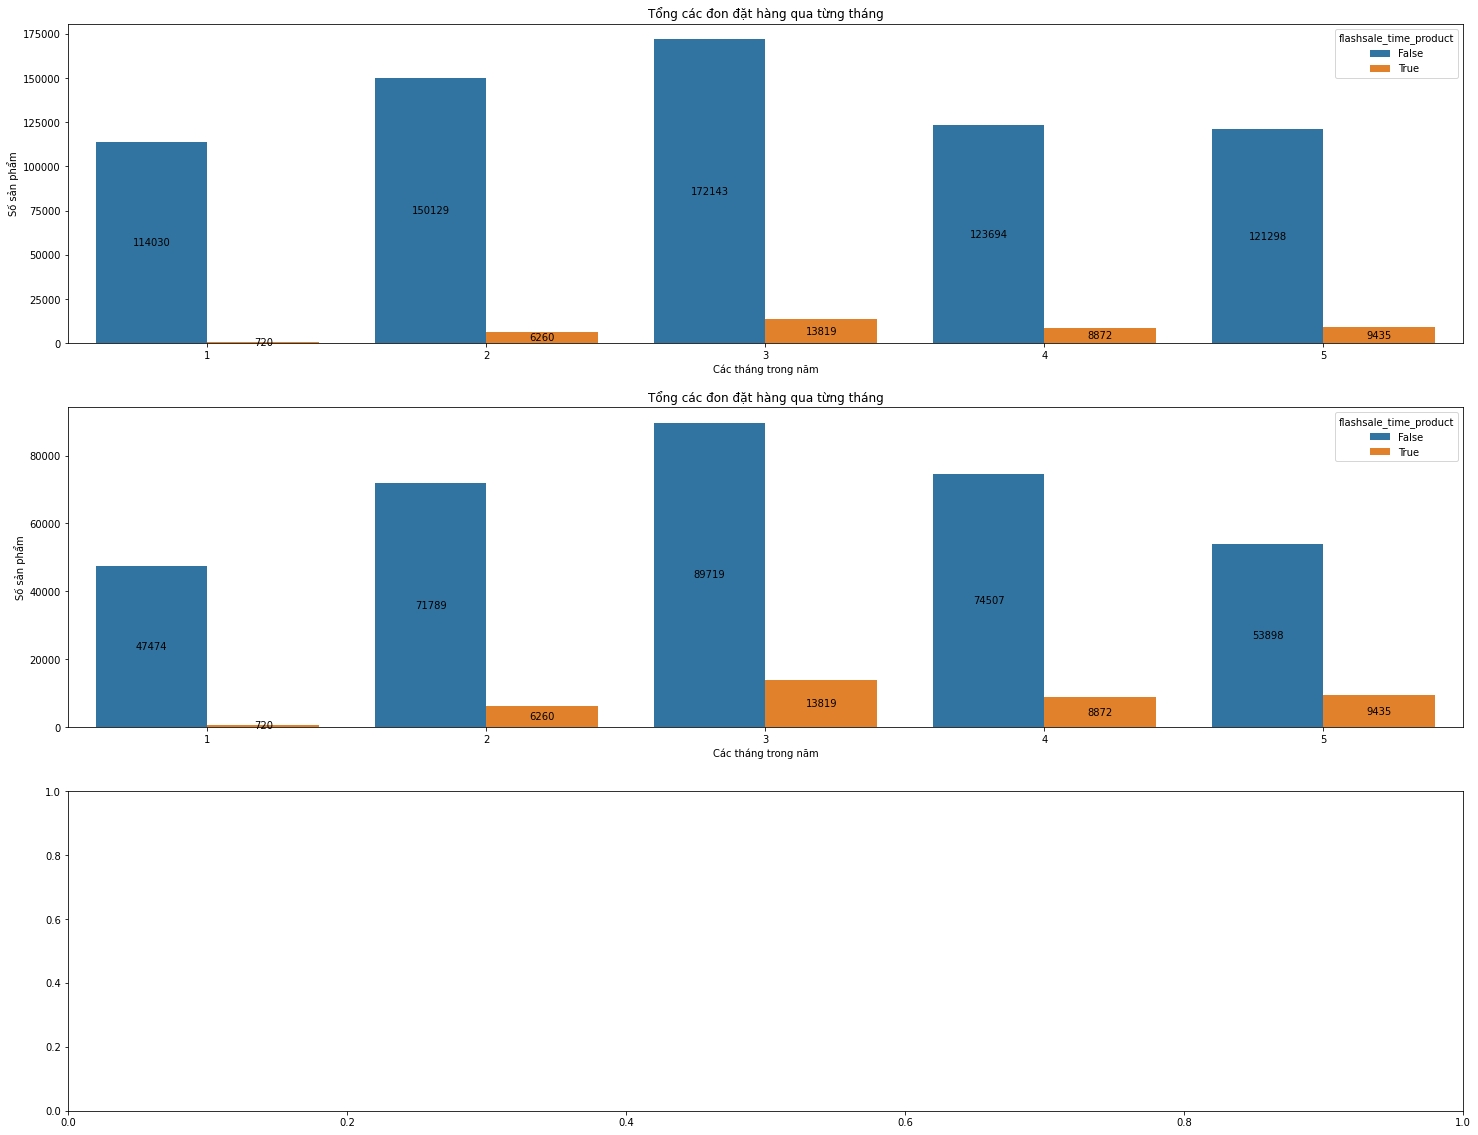

In [189]:
fig, ax = plt.subplots(3, 1, figsize=(25,20))

# Show ra khác biệt về ngày
sns.barplot(data = fhs_sales_flat_order_item_state_2022, 
          x = fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.month,
          y = fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_time_product', ax = ax[0], palette="tab10", estimator = np.count_nonzero)

for container in ax[0].containers:
    ax[0].bar_label(container, label_type='center')
ax[0].set_title('Tổng các đon đặt hàng qua từng tháng')
ax[0].set_xlabel('Các tháng trong năm')
ax[0].set_ylabel('Số sản phẩm')

df = fhs_sales_flat_order_item_state_2022\
        .loc[(fhs_sales_flat_order_item_state_2022['flashsale_product'] ==  True)]

sns.barplot(data = df, 
          x = df['fhs_sales_flat_order_item.created_at'].dt.month,
          y = df['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_time_product', ax = ax[1], palette="tab10", estimator = np.count_nonzero)

for container in ax[1].containers:
    ax[1].bar_label(container, label_type='center')
ax[1].set_title('Tổng các đon đặt hàng qua từng tháng')
ax[1].set_xlabel('Các tháng trong năm')
ax[1].set_ylabel('Số sản phẩm')

- So sánh giữa lượng mua hàng của loại hàng flashsale trong ngày flashsale và trong thời gian flashsale

Text(0.5, 1.0, 'Lượng mua hàng trung bình của hàng flashsale theo ngày trong tuần')

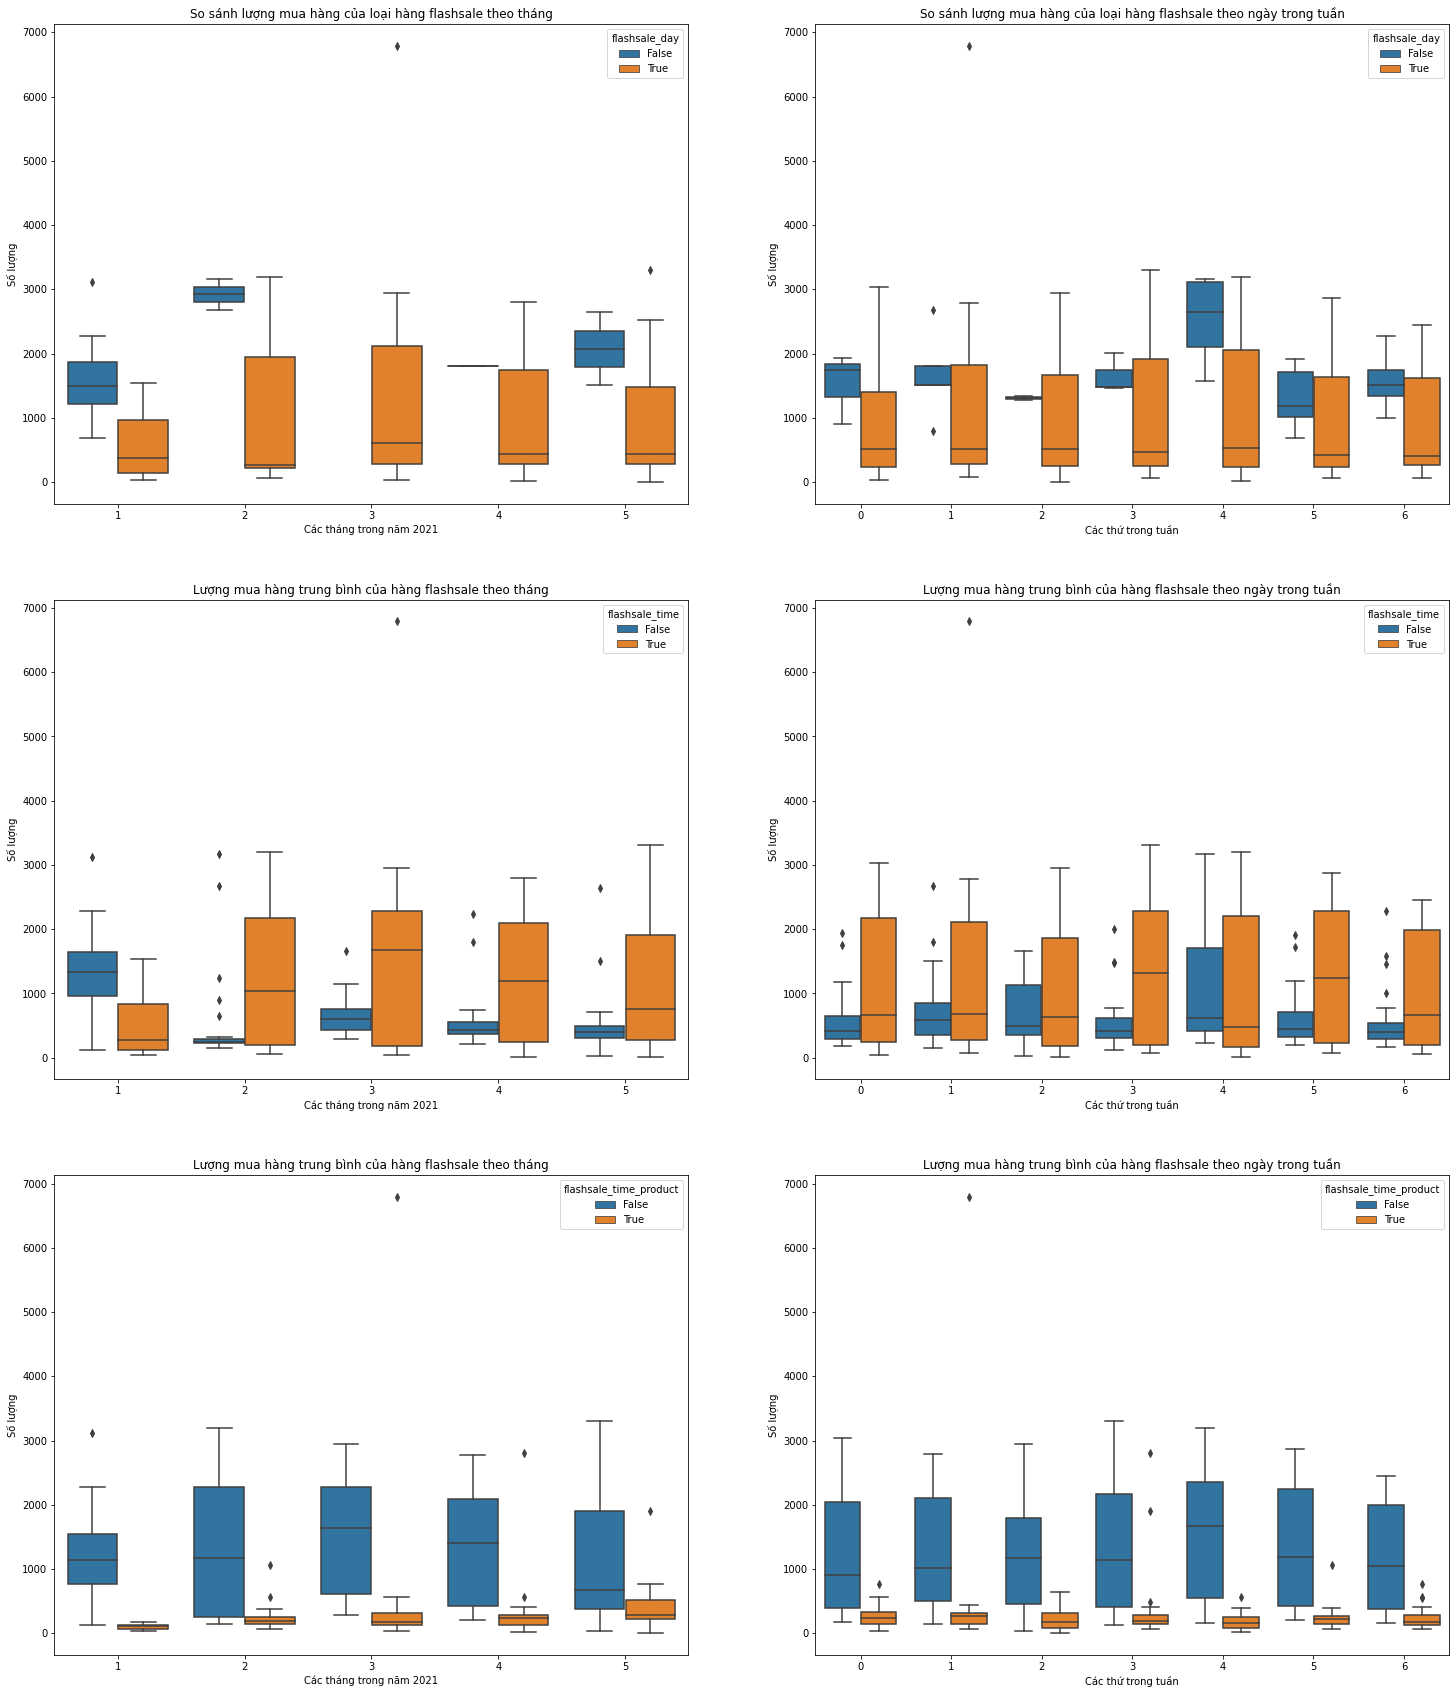

In [159]:
df = fhs_sales_flat_order_item_state_2022         \
          .groupby([fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'].dt.date,
                    'flashsale_product', 'flashsale_day', 'flashsale_time', 'flashsale_time_product'])\
                    ['fhs_sales_flat_order.entity_id'].count()

# reset index đưa về dataframe
df = df.reset_index()

# khi reset_index inedx đã đưa về sting nên ta cast về datetime
string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')

fig, ax = plt.subplots(3, 2, figsize=(25,30))

# Show ra khác biệt về ngày
df1 = df.loc[df['flashsale_product'] == True]
sns.boxplot(data = df1, 
          x = df1['fhs_sales_flat_order_item.created_at'].dt.month,
          y = df1['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_day', ax = ax[0, 0], palette="tab10")
ax[0, 0].set_ylabel('Số lượng')
ax[0, 0].set_title('So sánh lượng mua hàng của loại hàng flashsale theo tháng')
ax[0, 0].set_xlabel('Các tháng trong năm 2021')

sns.boxplot(data = df1, 
          x = df1['fhs_sales_flat_order_item.created_at'].dt.dayofweek,
          y = df1['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_day', ax = ax[0, 1], palette="tab10")
ax[0, 1].set_ylabel('Số lượng')
ax[0, 1].set_title('So sánh lượng mua hàng của loại hàng flashsale theo ngày trong tuần')
ax[0, 1].set_xlabel('Các thứ trong tuần')



# show ra khác biệt về thời điểm
df2 = df.loc[df['flashsale_product'] == True]
sns.boxplot(data = df2, 
          x = df2['fhs_sales_flat_order_item.created_at'].dt.month,
          y = df2['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_time', ax = ax[1, 0],palette = "tab10")
ax[1, 0].set_xlabel('Các tháng trong năm 2021')
ax[1, 0].set_ylabel('Số lượng')
ax[1, 0].set_title('Lượng mua hàng trung bình của hàng flashsale theo tháng')

sns.boxplot(data = df2, 
          x = df2['fhs_sales_flat_order_item.created_at'].dt.dayofweek,
          y = df2['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_time', ax = ax[1, 1],palette = "tab10")
ax[1, 1].set_xlabel('Các thứ trong tuần')
ax[1, 1].set_ylabel('Số lượng')
ax[1, 1].set_title('Lượng mua hàng trung bình của hàng flashsale theo ngày trong tuần')



# show ra khác biệt về thời điểm mua hàng flashsale
df3 = df.loc[df['flashsale_product'] == True]
sns.boxplot(data = df3, 
          x = df3['fhs_sales_flat_order_item.created_at'].dt.month,
          y = df3['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_time_product', ax = ax[2, 0],palette = "tab10")
ax[2, 0].set_xlabel('Các tháng trong năm 2021')
ax[2, 0].set_ylabel('Số lượng')
ax[2, 0].set_title('Lượng mua hàng trung bình của hàng flashsale theo tháng')

sns.boxplot(data = df3, 
          x = df3['fhs_sales_flat_order_item.created_at'].dt.dayofweek,
          y = df3['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_time_product', ax = ax[2, 1],palette = "tab10")
ax[2, 1].set_xlabel('Các thứ trong tuần')
ax[2, 1].set_ylabel('Số lượng')
ax[2, 1].set_title('Lượng mua hàng trung bình của hàng flashsale theo ngày trong tuần')




- Show ra các ngày trong tháng

Text(0.5, 0, 'Các ngày trong tháng')

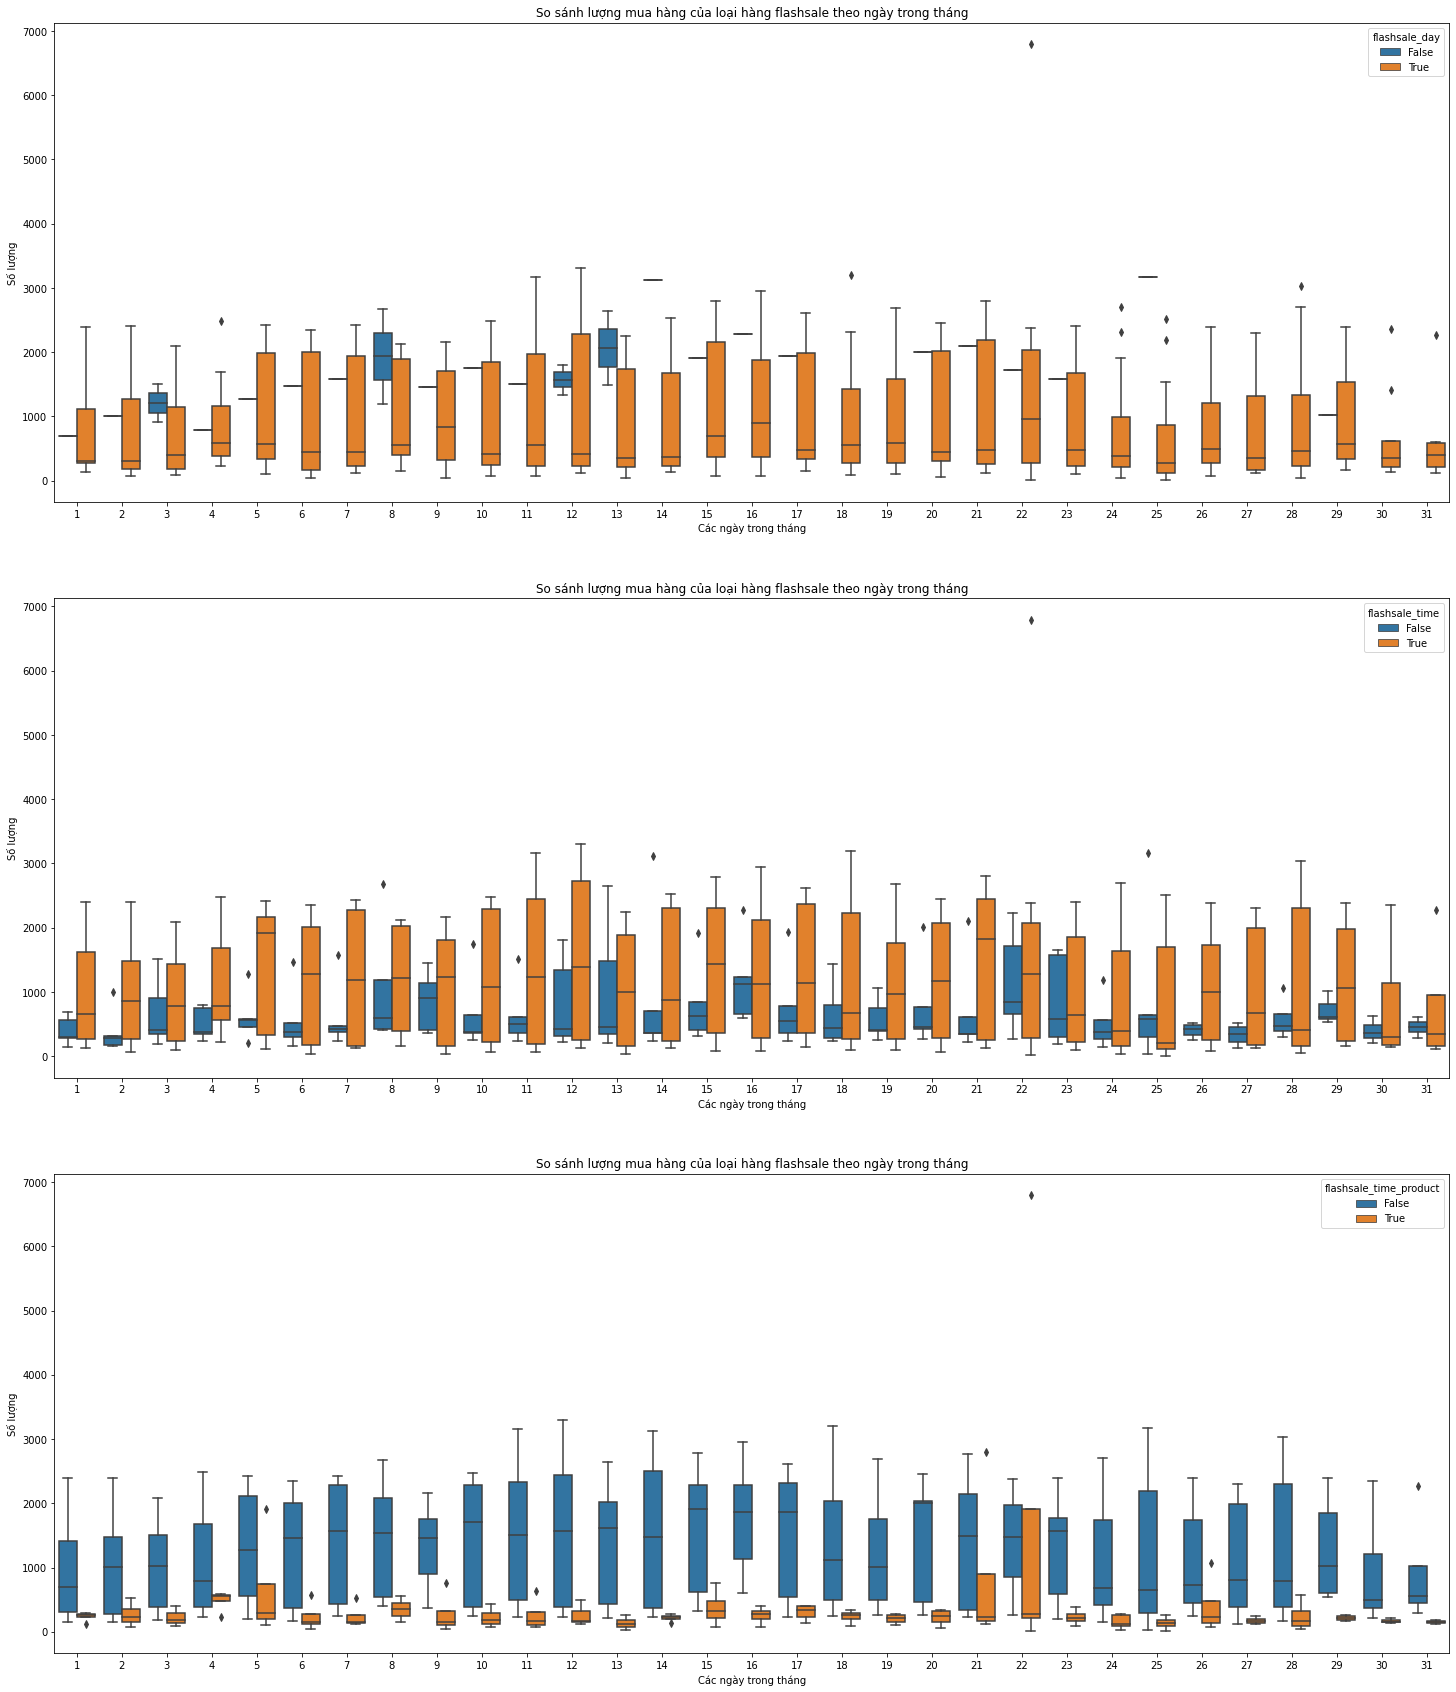

In [160]:

fig, ax = plt.subplots(3, 1, figsize=(25,30))

sns.boxplot(data = df1, 
          x = df1['fhs_sales_flat_order_item.created_at'].dt.day,
          y = df1['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_day', ax = ax[0], palette="tab10")
ax[0].set_ylabel('Số lượng')
ax[0].set_title('So sánh lượng mua hàng của loại hàng flashsale theo ngày trong tháng')
ax[0].set_xlabel('Các ngày trong tháng')

sns.boxplot(data = df1, 
          x = df1['fhs_sales_flat_order_item.created_at'].dt.day,
          y = df1['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_time', ax = ax[1], palette="tab10")
ax[1].set_ylabel('Số lượng')
ax[1].set_title('So sánh lượng mua hàng của loại hàng flashsale theo ngày trong tháng')
ax[1].set_xlabel('Các ngày trong tháng')

sns.boxplot(data = df1, 
          x = df1['fhs_sales_flat_order_item.created_at'].dt.day,
          y = df1['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_time_product', ax = ax[2], palette="tab10")
ax[2].set_ylabel('Số lượng')
ax[2].set_title('So sánh lượng mua hàng của loại hàng flashsale theo ngày trong tháng')
ax[2].set_xlabel('Các ngày trong tháng')

Text(0.5, 0, 'Các tháng trong ngày')

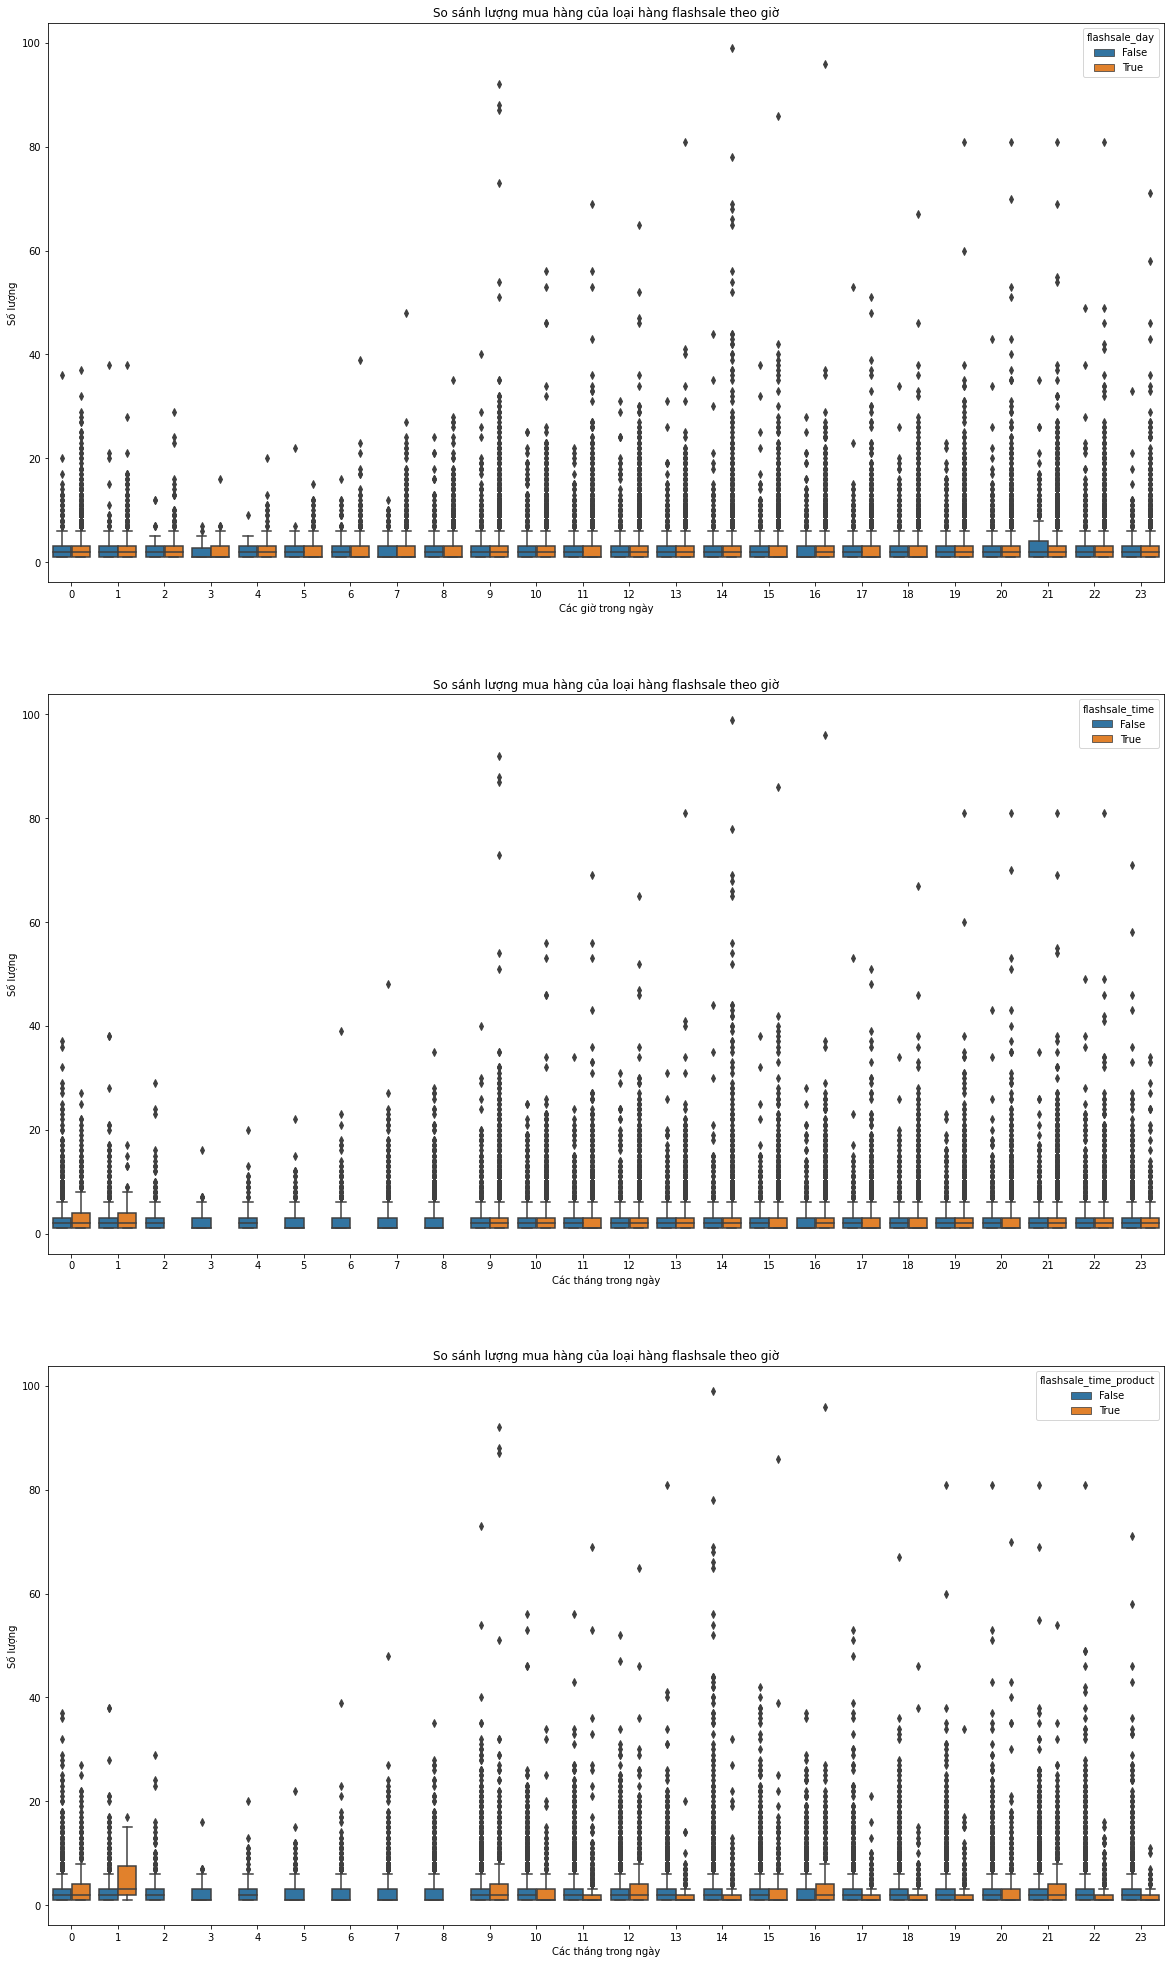

In [161]:
df = fhs_sales_flat_order_item_state_2022         \
          .groupby([fhs_sales_flat_order_item_state_2022['fhs_sales_flat_order_item.created_at'],
                    'flashsale_product', 'flashsale_day', 'flashsale_time', 'flashsale_time_product'])\
                    ['fhs_sales_flat_order.entity_id'].count()

# reset index đưa về dataframe
df = df.reset_index()

# khi reset_index inedx đã đưa về sting nên ta cast về datetime
string_to_datetime(df, 'fhs_sales_flat_order_item.created_at')

fig, ax = plt.subplots(3, 1, figsize=(20,35))

# Show ra khác biệt về giờ
df1 = df.loc[df['flashsale_product'] == True]
sns.boxplot(data = df1, 
          x = df1['fhs_sales_flat_order_item.created_at'].dt.hour,
          y = df1['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_day', ax = ax[0], palette="tab10")
ax[0].set_ylabel('Số lượng')
ax[0].set_title('So sánh lượng mua hàng của loại hàng flashsale theo giờ')
ax[0].set_xlabel('Các giờ trong ngày')

# Show ra khác biệt về giờ
sns.boxplot(data = df1, 
          x = df1['fhs_sales_flat_order_item.created_at'].dt.hour,
          y = df1['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_time', ax = ax[1], palette="tab10")
ax[1].set_ylabel('Số lượng')
ax[1].set_title('So sánh lượng mua hàng của loại hàng flashsale theo giờ')
ax[1].set_xlabel('Các tháng trong ngày')

# Show ra khác biệt về giờ
sns.boxplot(data = df1, 
          x = df1['fhs_sales_flat_order_item.created_at'].dt.hour,
          y = df1['fhs_sales_flat_order.entity_id'],
          hue = 'flashsale_time_product', ax = ax[2], palette="tab10")
ax[2].set_ylabel('Số lượng')
ax[2].set_title('So sánh lượng mua hàng của loại hàng flashsale theo giờ')
ax[2].set_xlabel('Các tháng trong ngày')


- Tỉ lệ phần trăm mà sản phẩm flashsale bán được trong tháng, ngày trong tuần, ngày trong tháng, và theo giờ

In [162]:
# Lấy ra các đơn hàng flashsale_time_product = True 
# bao gồm cả complete và canceled
df = fhs_sales_flat_order_item_state_2022\
          .loc[fhs_sales_flat_order_item_state_2022['flashsale_time_product'] == True]

temp = pd.merge(df, fhs_flashsale_product_info_2022,
                    left_on='fhs_sales_flat_order_item.sku',
                    right_on='fhs_catalog_product_entity.sku')

temp = temp.loc[(temp['fhs_sales_flat_order_item.created_at'] > temp['fhs_flashsale_period.start_date'])
&               (temp['fhs_sales_flat_order_item.created_at'] < temp['fhs_flashsale_period.end_date'])]

temp.drop_duplicates(subset = fhs_sales_flat_order_item_state_2022.columns, inplace = True)

In [163]:
temp

,fhs_sales_flat_order.entity_id,fhs_sales_flat_order.increment_id,fhs_sales_flat_order.state,fhs_sales_flat_order.status,fhs_sales_flat_order.created_at,fhs_sales_flat_order.updated_at,fhs_sales_flat_order.store_id,fhs_sales_flat_order_item.item_id,fhs_sales_flat_order_item.order_id,fhs_sales_flat_order_item.created_at,...,fhs_flashsale_product.original_price,fhs_flashsale_product.flashsale_price,fhs_flashsale_product.total_items,fhs_flashsale_period.id,fhs_flashsale_period.start_date,fhs_flashsale_period.end_date,fhs_catalog_product_entity.entity_id,fhs_catalog_product_entity.sku,fhs_catalog_product_entity.created_at,fhs_catalog_product_entity.discount_percent
21,5046770,102387056.0,complete,complete,2022-01-24 09:59:13,2022-01-24 10:00:15,1,16665994,5046770,2022-01-24 16:59:13,...,79000.0,11000.0,3.0,6200,2022-01-24 16:00:00,2022-01-24 16:59:59,347451,8809696993038,2021-02-25 08:30:12,0.0
291,5049300,102387975.0,complete,complete,2022-01-25 09:00:32,2022-01-25 16:00:32,1,16673715,5049300,2022-01-25 16:00:32,...,79000.0,11000.0,3.0,6213,2022-01-25 16:00:00,2022-01-25 16:59:59,347451,8809696993038,2021-02-25 08:30:12,0.0
548,5049303,102387978.0,complete,complete,2022-01-25 09:01:19,2022-01-25 16:01:19,1,16673727,5049303,2022-01-25 16:01:19,...,79000.0,11000.0,3.0,6213,2022-01-25 16:00:00,2022-01-25 16:59:59,347451,8809696993038,2021-02-25 08:30:12,0.0
805,5049306,400898525.0,complete,complete,2022-01-25 09:02:03,2022-01-25 16:02:03,4,16673732,5049306,2022-01-25 16:02:03,...,79000.0,11000.0,3.0,6213,2022-01-25 16:00:00,2022-01-25 16:59:59,347451,8809696993038,2021-02-25 08:30:12,0.0
1068,5052321,400899188.0,complete,complete,2022-01-26 05:10:03,2022-01-26 05:10:41,4,16680917,5052321,2022-01-26 12:10:03,...,79000.0,11000.0,3.0,6388,2022-01-26 12:00:00,2022-01-26 12:59:59,347451,8809696993038,2021-02-25 08:30:12,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1635525,5536239,401021995.0,complete,complete,2022-05-23 15:08:39,2022-05-23 15:52:35,4,17987760,5536239,2022-05-23 22:08:39,...,399000.0,219450.0,2.0,8420,2022-05-23 21:00:00,2022-05-23 22:59:59,272982,4052351019312,2020-01-03 09:19:58,45.0
1635671,5537228,102527838.0,complete,complete,2022-05-24 02:25:04,2022-05-24 02:26:22,1,17990670,5537228,2022-05-24 09:25:04,...,399000.0,239400.0,3.0,8421,2022-05-24 09:00:00,2022-05-24 09:59:59,341269,4006592036461,2021-01-13 02:14:33,40.0
1635756,5537638,401022327.0,complete,complete,2022-05-24 03:56:19,2022-05-24 03:56:59,4,17992123,5537638,2022-05-24 10:56:19,...,277000.0,235000.0,10.0,8422,2022-05-24 10:00:00,2022-05-24 10:59:59,343520,8935244853339,2021-01-25 08:13:24,15.0
1635955,5540471,102529178.0,complete,complete,2022-05-24 13:42:47,2022-05-24 20:42:47,1,18000428,5540471,2022-05-24 20:42:47,...,799000.0,479400.0,7.0,8432,2022-05-24 20:00:00,2022-05-24 20:59:59,274686,4006592025076,2020-01-30 02:48:46,40.0


- Tìm số ngày, giờ mà flashsale chiếm sóng để tính toán xem số lượng sản phẩm flashsale/ngày, flashsale/giờ

In [164]:
fhs_flashsale_period.groupby(['fhs_flashsale_period.start_date', 'fhs_flashsale_period.end_date']).count()

,,fhs_flashsale_period.id
fhs_flashsale_period.start_date,fhs_flashsale_period.end_date,
2002-12-21 12:05:00,2020-12-21 12:59:59,1
2018-12-19 10:00:01,2018-12-19 11:59:59,1
2018-12-19 12:00:01,2018-12-19 13:59:59,1
2018-12-19 14:15:01,2018-12-19 19:59:59,1
2018-12-19 20:00:01,2018-12-19 21:59:59,1
...,...,...
2022-05-27 17:00:00,2022-05-27 17:59:59,1
2022-05-27 18:00:00,2022-05-27 18:59:59,1
2022-05-27 19:00:00,2022-05-27 19:59:59,1


In [ ]:
fhs_flashsale_period

- Tiếp theo ta quan tâm tới catarories và giá

- Khác period id trong flash sale nhưng vẫn cùng ngày 
- Có thể lược bỏ, tuy nhiên có thể dẫn đến sai sót khi tính số lượng bán hàng chia cho total item

- Temp là sản phẩm flashsale = True, sản phẩm bán trong ngày flashsale_day = True, sản phẩm được bán trong flashsale_time = True

### cùng một sku, xem tần suất sale check những sản phẩm có tần suất sale lớn, xem sức bán có ổn định hay không

https://stackoverflow.com/questions/43954182/unable-to-align-bins-in-a-histogram-of-datetime-objects-using-the-hist-functio